# Simple Saliency Approach 

-------




(1414, 2121, 3)


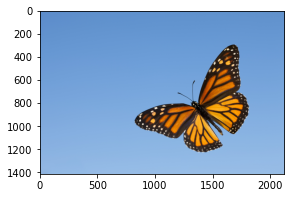

In [26]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
from skimage import data
from skimage.io import imread
from skimage.color import rgb2gray
from skimage.transform import resize
plt.rcParams["figure.figsize"] = (20,3)
import os
import fnmatch


img = imread('papillon.jpg')[:,:,:3]
img_rafale = imread('rafale.jpg')[:,:,:3]

gray = np.mean(img, axis = 2) # there exists other formulas to convert to gray but mean seems to work fine
print(img.shape)
plt.imshow(img)
plt.show()

##### This example is a simple case where the salient object can't be clearer to distinguish from the uniform background, the idea behind the algorithm should be most effective in this case

In [15]:
def spectralSaliency(img,width = 64, scale = None): #grayscale image
    #rescale image to lower resolution
    if scale is None:
        img = cv2.resize(img, (width,int(width*img.shape[0]/img.shape[1])))
    else:
        img = cv2.resize(img, (int(img.shape[1] * scale), int(img.shape[0] * scale)) )
    
    # apply discrete fourier transform on image 
    
    c = cv2.dft(np.float32(img), flags = cv2.DFT_COMPLEX_OUTPUT)
    
    # compute magnitude  
    mag = np.sqrt(c[:,:,0]**2 + c[:,:,1]**2)
    
    # magnitude is passed through a 3*3 mean filter and compared to original magintude
    # we use log since our assumption concerns the shape of natural images' log magnitude shape (see article)
    spectralResidual = np.exp(np.log(mag) - cv2.boxFilter(np.log(mag), -1, (3,3)))

    #we reconstruct the image weighted by residual
    c[:,:,0] = c[:,:,0] * spectralResidual / mag
    c[:,:,1] = c[:,:,1] * spectralResidual / mag
    c = cv2.dft(c, flags = (cv2.DFT_INVERSE | cv2.DFT_SCALE))
    saliency_map = c[:,:,0]**2 + c[:,:,1]**2
    # we apply a gaussian filter for smoothing
    saliency_map = cv2.normalize(cv2.GaussianBlur(saliency_map,(9,9),3,3), saliency_map, 0., 1., cv2.NORM_MINMAX)
    return np.float32(saliency_map)
    

In [134]:
saliency_map_64 = spectralSaliency(gray,64)

#### We can see the impact of width parameter which controls the level of irregularities we are interested in (more size = more details, less size = more big picture elements) .


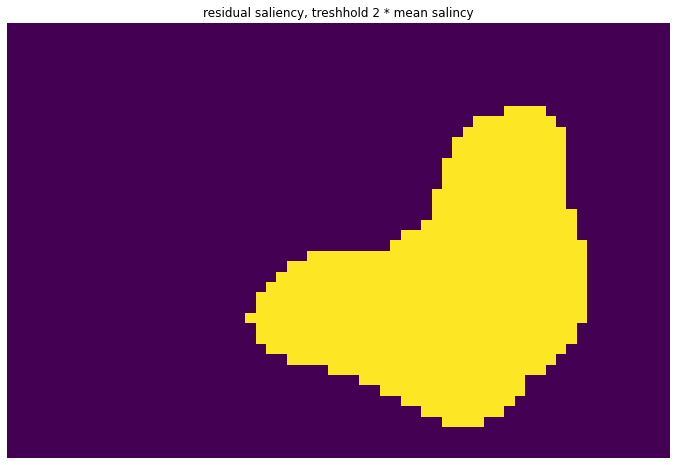

In [135]:
plt.figure(figsize=(15,8))
plt.imshow(saliency_map_64 > 2 * saliency_map_64.mean())
plt.title("residual saliency, treshhold 2 * mean salincy")
plt.axis("off")
plt.show()

#### the scale should be fixed for each image , it is related to the image resolution and also object size in the image 

In [52]:
def predict(img,width):
    gray = np.mean(img,axis = 2)
    s_map = spectralSaliency(gray,width=width)
    s_map = (s_map > 2 * s_map.mean()) * 1
    rs_map = resize(image=s_map, output_shape=gray.shape) # resized saliency map
    return rs_map

def MAE(prediction,ground_truth):
    return np.mean(np.abs(prediction - ground_truth/255))

In [53]:
import tqdm
import pandas as pd

In [136]:
img_folder = "./DUT-OMRON-image/"
gt_folder = "./pixelwiseGT-new-PNG/"
score_dict = {}
width = 64
for file in tqdm.tqdm(os.listdir(img_folder)):
    if fnmatch.fnmatch(file, "*.jpg") or fnmatch.fnmatch(file, "*.jpeg") or fnmatch.fnmatch(file, "*.png") :
        filename = file.split('.')[0]
        try:
            im = imread(img_folder + filename + ".jpg")[:,:,:3] # no need for alpha channel 
            gt = imread(gt_folder + filename + ".png")
            rs_map = predict(im,width)
            #print(im.shape,gt.shape, rs_map.shape)
            score = MAE(prediction=rs_map, ground_truth=gt)
            score_dict[filename] = score
        except:
            print(filename)
            continue


100%|██████████████████████████████████████████████████████████████████████████████| 5168/5168 [01:35<00:00, 53.90it/s]


In [137]:
score_df = pd.DataFrame.from_dict(score_dict, orient = "index", columns=["MAE"]).reset_index().rename(columns={"index": "img_name"})
score_df.head(3)

,img_name,MAE
0,im005,0.114240
1,im010,0.126150
2,im013,0.084975


In [138]:
score_df.describe()

,MAE
count,5168.000000
mean,0.148516
std,0.121517
min,0.000326
25%,0.051816
50%,0.116096
75%,0.217651
max,0.803951


#### mean MAE on this dataset is 0.14

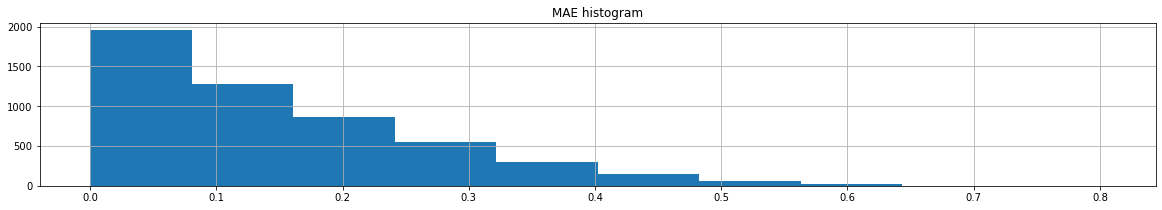

In [139]:
score_df.hist()
plt.title("MAE histogram")
plt.show()

### some good cases:

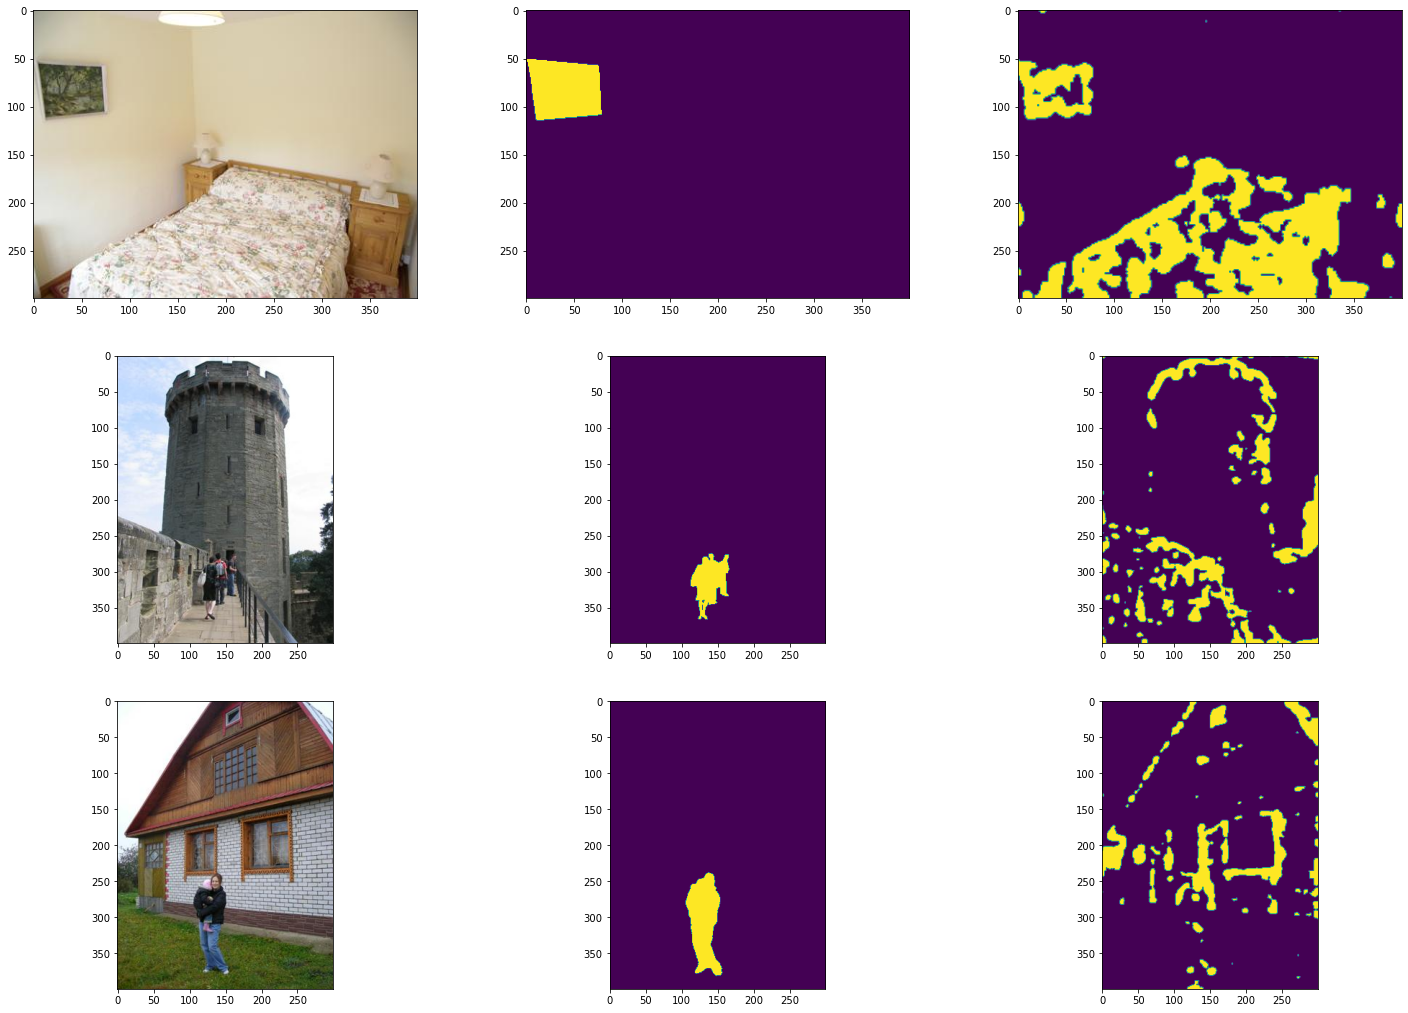

In [140]:
good_sample = score_df[score_df.MAE < score_df.MAE.quantile(0.20)].sample(3)
plt.figure(figsize=(25,18))
for i in range(len(good_sample)):
    im_name = good_sample.iloc[i].img_name
    im_ = imread(img_folder + im_name + ".jpg")
    gt_ = imread(gt_folder + im_name + ".png")
    prediction_ = predict(im_,width)
    plt.subplot(len(good_sample),3,3*i+1)
    plt.imshow(im_)
    plt.subplot(len(good_sample),3,3*i+2)
    plt.imshow(gt_)
    plt.subplot(len(good_sample),3,3*i+3)
    plt.imshow(prediction_)
plt.show()

### some bad cases:

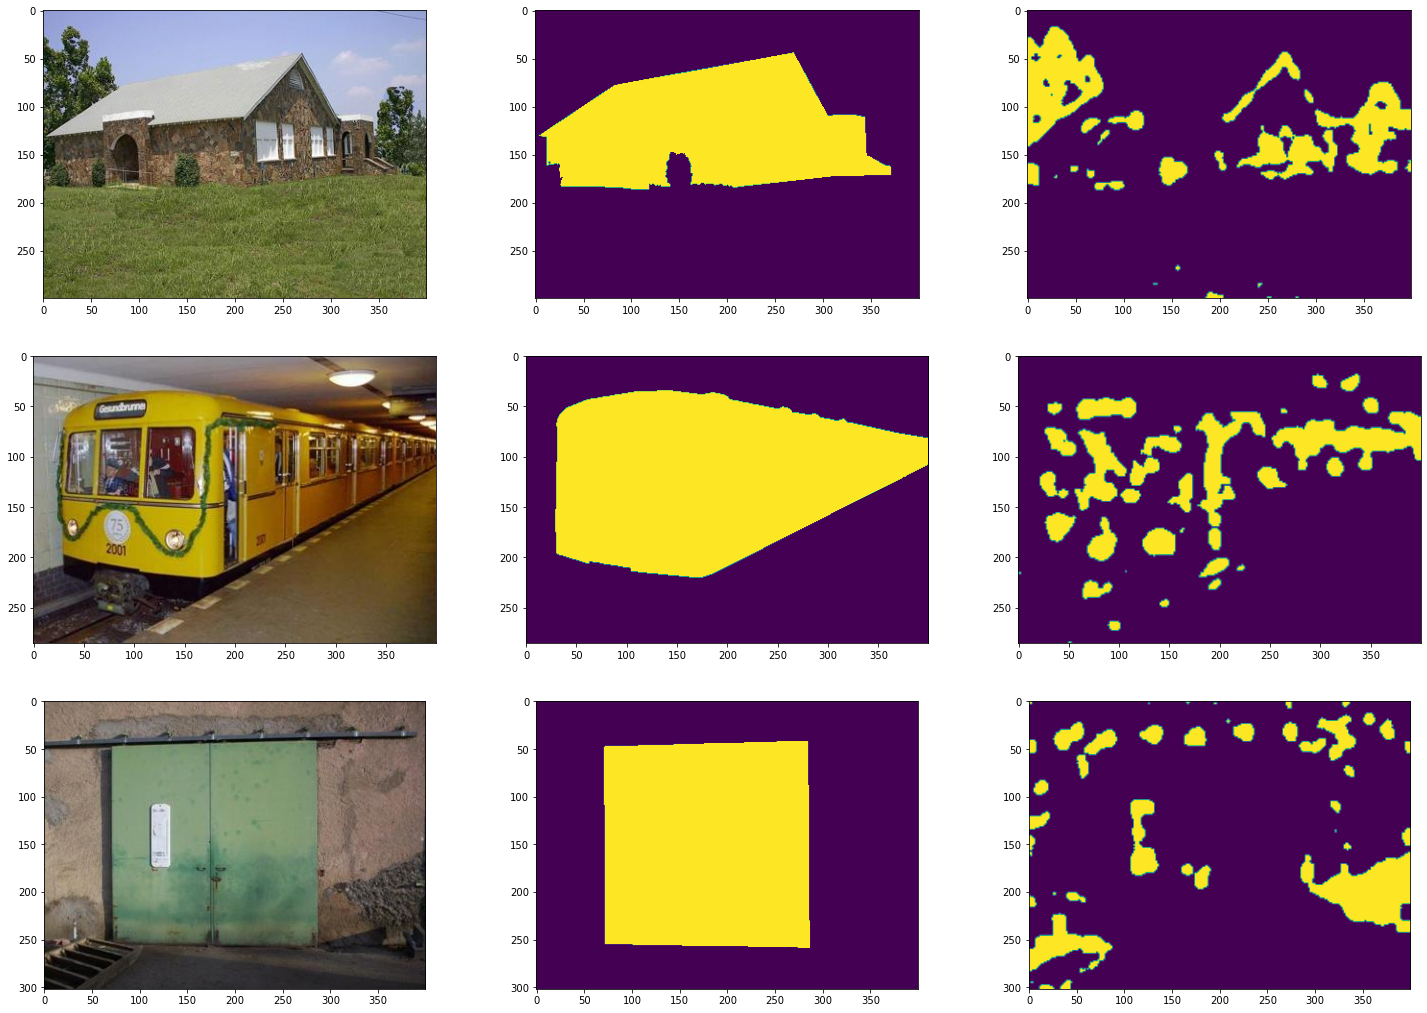

In [141]:
bad_sample = score_df[score_df.MAE > score_df.MAE.quantile(0.80)].sample(3)
plt.figure(figsize=(25,18))
for i in range(len(bad_sample)):
    im_name = bad_sample.iloc[i].img_name
    im_ = imread(img_folder + im_name + ".jpg")
    gt_ = imread(gt_folder + im_name + ".png")
    prediction_ = predict(im_,width)
    plt.subplot(len(bad_sample),3,3*i+1)
    plt.imshow(im_)
    plt.subplot(len(bad_sample),3,3*i+2)
    plt.imshow(gt_)
    plt.subplot(len(bad_sample),3,3*i+3)
    plt.imshow(prediction_)
plt.show()